# **Introduction**

## **Project Overview**
This project is a final assignment for **ISM 6251 Machine Learning at the University of South Florida (USF)**. Our goal was to apply what we’ve learned throughout the course in a practical, beginner-level project.
<br>
<br>

**Project Significance**: In today’s world, companies and organizations need simple tools to help identify real news from misleading or fake content. This project aims to provide a **basic, real-time tool** for media companies, social platforms, and fact-checkers to spot unreliable news.
<br>
<br>

We explored three algorithms—**Support Vector Machine (SVM)**, **Logistic Regression**, and **Naive Bayes**—to see which could best accomplish this task. **SVM** performed the best and is our recommended choice for a basic news filtering tool that helps organizations identify and review news content quickly and effectively.
<br>
<br>

[Dataset taken from Kaggle
](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification)
<br>
<br>
*Members: Kai Quander, Niharika Malyala, Ryan Stopczynski, Sucharitha Reddy, Zahid Rahman*

# **Importing libraries and dropping missing values**

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import csv
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WELFake_Dataset.csv')

# Check for missing values and display the count for each column
missing_values = df.isnull().sum()

# Format the output nicely
print("Missing Values:")
print(missing_values[missing_values > 0].to_string())

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print("\nDuplicate Rows:", duplicate_rows)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing Values:
title    558
text      39

Duplicate Rows: 0


In [ ]:
print(f"Total number of rows: {len(df)}")
df = df.dropna()
print(f"Number of rows after dropping missing values: {len(df)}")

Total number of rows: 72134
Number of rows after dropping missing values: 71537


# **EDA**

Distribution of the DV

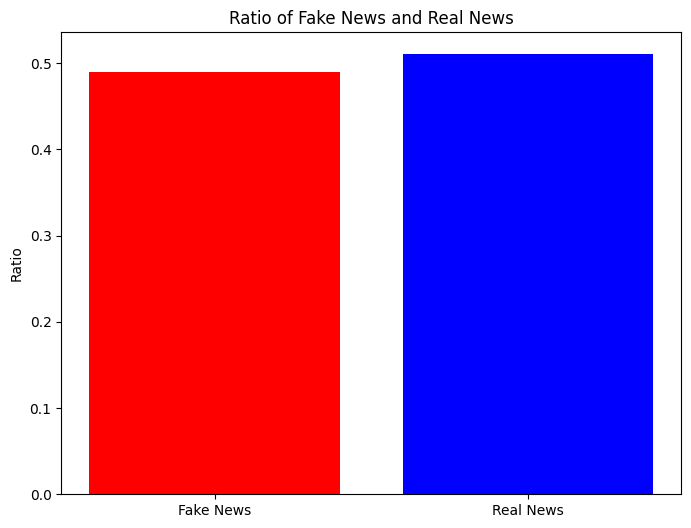

Ratio of Fake News: 0.49
Ratio of Real News: 0.51


In [ ]:
import matplotlib.pyplot as plt

# Calculate the ratio of 'label' values
label_counts = df['label'].value_counts()
ratio_fake = label_counts[0] / len(df)
ratio_real = label_counts[1] / len(df)

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(['Fake News', 'Real News'], [ratio_fake, ratio_real], color=['red', 'blue'])
plt.title('Ratio of Fake News and Real News')
plt.ylabel('Ratio')
plt.show()

# Print the ratio for better readability
print(f"Ratio of Fake News: {ratio_fake:.2f}")
print(f"Ratio of Real News: {ratio_real:.2f}")

# Pretty even split

Distribution of Title Lengths

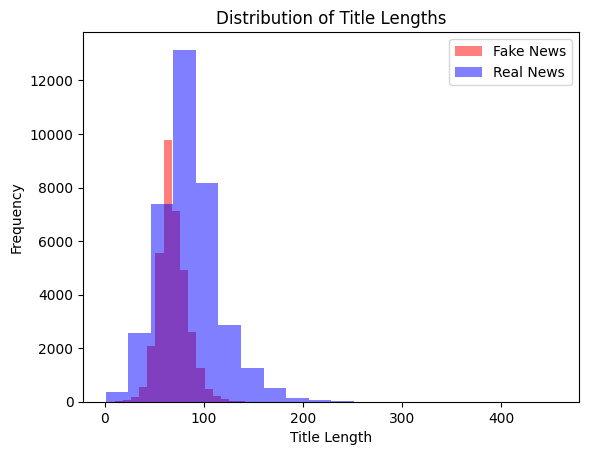

In [ ]:
# Assuming 'title' is the column containing the news titles
df['title_length'] = df['title'].str.len()

# Create separate dataframes for fake and real news
fake_news = df[df['label'] == 0]
real_news = df[df['label'] == 1]

# Plot the distribution of title lengths for fake news
plt.hist(fake_news['title_length'], bins=20, alpha=0.5, label='Fake News', color='red')

# Plot the distribution of title lengths for real news
plt.hist(real_news['title_length'], bins=20, alpha=0.5, label='Real News', color='blue')

plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Distribution of Title Lengths')
plt.legend(loc='upper right')
plt.show()

#Fake news often has shorter, punchier titles, likely aimed at grabbing attention quickly,
#while real news titles vary more in length, possibly reflecting a focus on detail and accuracy.

Distribution of Text Lengths

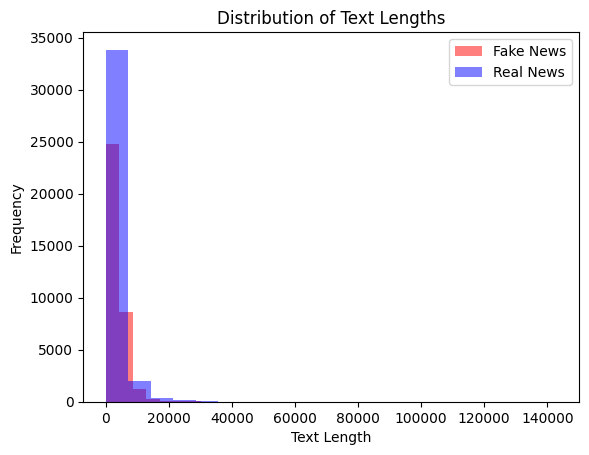

In [ ]:
# Calculate the length of each article using the "text" column
df['text_length'] = df['text'].str.len()

# Create separate dataframes for fake and real news
fake_news = df[df['label'] == 0]
real_news = df[df['label'] == 1]

# Plot the distribution of text lengths for fake news
plt.hist(fake_news['text_length'], bins=20, alpha=0.5, label='Fake News', color='red')

# Plot the distribution of text lengths for real news
plt.hist(real_news['text_length'], bins=20, alpha=0.5, label='Real News', color='blue')

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend(loc='upper right')
plt.show()

# real news articles tend to be longer in lengths than fake news articles

Tri-gram Word Cloud using stratified sampling  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


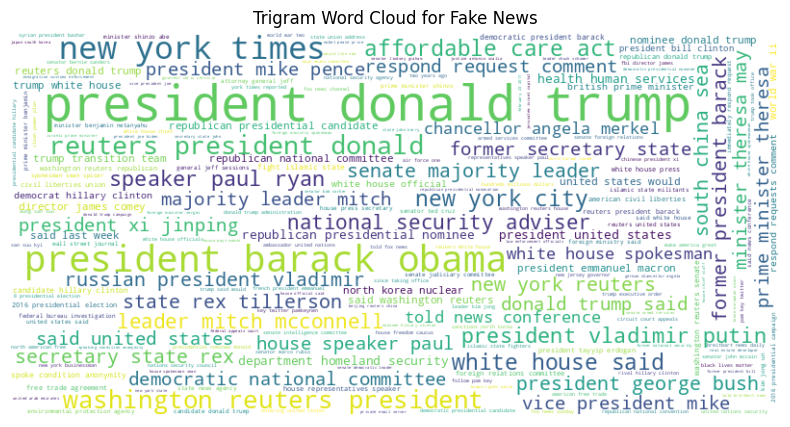

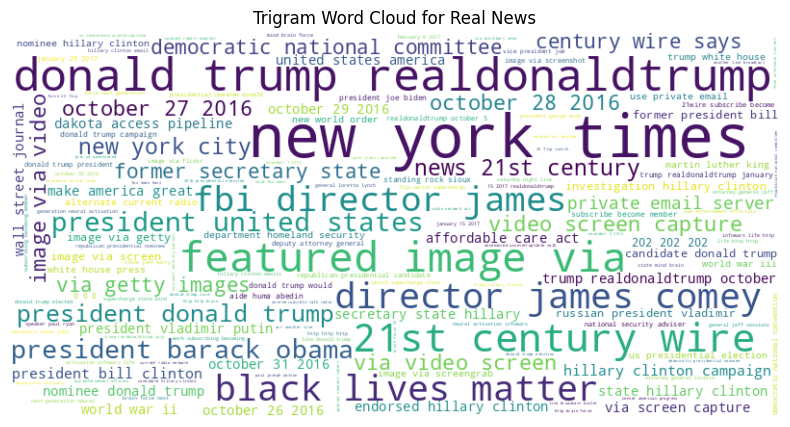

In [ ]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.model_selection import StratifiedShuffleSplit

nltk.download('stopwords')
nltk.download('punkt')

# Stratified sampling (10% of the dataset)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df, df['label']):
  sampled_df = df.iloc[test_index]

# Create separate dataframes for fake and real news from the sampled data
fake_news_sampled = sampled_df[sampled_df['label'] == 0]
real_news_sampled = sampled_df[sampled_df['label'] == 1]


def generate_trigram_wordcloud(df, label_name):
  text = " ".join(df['text'].astype(str))
  tokens = nltk.word_tokenize(text.lower())
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [w for w in tokens if not w in stop_words and w.isalnum()]
  trigrams = list(ngrams(filtered_tokens, 3))
  trigram_counts = {}
  for trigram in trigrams:
    trigram_str = ' '.join(trigram)
    if trigram_str in trigram_counts:
      trigram_counts[trigram_str] += 1
    else:
      trigram_counts[trigram_str] = 1

  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_counts)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"Trigram Word Cloud for {label_name} News")
  plt.show()


generate_trigram_wordcloud(fake_news_sampled, "Fake")
generate_trigram_wordcloud(real_news_sampled, "Real")

# **Preprocessing**



Text Cleaning
*** (THIS CODE BLOCK TAKES 20 MINUTES TO FULLY EXECUTE DUE TO DATASET & SAMPLE SIZE)***

In [ ]:
import re
import spacy
!pip install swifter
import swifter  # For parallel processing
import pandas as pd

# Load SpaCy's English model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Define the custom stopword list
custom_stop_words = { "a", "about", "above", "according", "accordingly", "across", "actually", "after", "afterwards", "again", "against",
    "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among",
    "amongst", "an", "and", "another", "any", "anybody", "anyhow", "anyone", "anything", "anyway", "anyways", "anywhere",
    "apart", "appear", "appreciate", "appropriate", "are", "aren’t", "around", "as", "a’s", "back", "be", "became",
    "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being", "believe", "below",
    "beside", "besides", "best", "better", "between", "beyond", "both", "brief", "but", "by", "be’s", "came", "can",
    "can’t", "cannot", "cant", "cause", "causes", "certain", "certainly", "changes", "clearly", "co", "com", "come",
    "comes", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "could",
    "couldn’t", "course", "currently", "definite", "definitely", "described", "despite", "did", "didn’t", "different",
    "do", "does", "doesn’t", "doing", "don’t", "done", "down", "downwards", "during", "each", "edu", "eg", "eight",
    "either", "else", "elsewhere", "enough", "entirely", "especially", "et", "etc", "even", "ever", "every", "everybody",
    "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "far", "few", "fifth", "first", "five",
    "followed", "following", "follows", "for", "former", "formerly", "forth", "four", "from", "further", "furthermore",
    "get", "gets", "getting", "given", "gives", "go", "goes", "going", "gone", "got", "gotten", "greetings", "had",
    "hadn’t", "happens", "hardly", "has", "hasn’t", "have", "haven’t", "having", "he", "he’d", "he’ll", "he’s", "hello",
    "help", "hence", "her", "here", "here’s", "hers", "herself", "hi", "him", "himself", "his", "hither", "hopefully",
    "how", "howbeit", "however", "how’s", "i", "i’d", "i’ll", "i’m", "i’ve", "ie", "if", "ignored", "immediate", "in",
    "inasmuch", "inc", "indeed", "indicate", "indicated", "indicates", "inner", "insofar", "instead", "into", "inward",
    "is", "isn’t", "it", "it’d", "it’ll", "it’s", "its", "itself", "just", "keep", "keeps", "kept", "know", "known",
    "knows", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "let’s", "like", "liked",
    "likely", "little", "look", "looking", "looks", "low", "lower", "ltd", "made", "mainly", "make", "makes", "making",
    "many", "may", "maybe", "me", "mean", "meanwhile", "merely", "might", "more", "moreover", "most", "mostly", "much",
    "must", "my", "myself", "name", "namely", "nd", "near", "nearly", "necessary", "need", "needs", "neither", "never",
    "neverf", "neverless", "new", "next", "nine", "no", "nobody", "non", "none", "nonetheless", "noone", "nor",
    "normally", "not", "nothing", "novel", "now", "nowhere", "obviously", "of", "off", "often", "oh", "ok", "okay",
    "old", "on", "once", "one", "ones", "only", "onto", "or", "other", "others", "otherwise", "ought", "our", "ours",
    "ourselves", "out", "outside", "over", "overall", "own", "particular", "particularly", "per", "perhaps", "placed",
    "please", "plus", "possible", "presumably", "probably", "provides", "que", "quite", "qv", "rather", "rd", "re",
    "really", "reasonably", "regarding", "regardless", "regards", "relatively", "respectively", "right", "round",
    "run", "said", "same", "saw", "say", "saying", "says", "second", "secondly", "see", "seeing", "seem", "seemed",
    "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several",
    "shall", "she", "she’d", "she’ll", "she’s", "should", "shouldn’t", "since", "six", "so", "some", "somebody",
    "someday", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "soon", "sorry", "specified",
    "specify", "specifying", "still", "sub", "such", "sup", "sure", "take", "taken", "taking", "tell", "tends", "th",
    "than", "thank", "thanks", "thanx", "that", "that’s", "the", "their", "theirs", "them", "themselves", "then",
    "thence", "there", "there’s", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they",
    "they’d", "they’ll", "they’re", "they’ve", "think", "third", "this", "those", "though", "three", "through",
    "throughout", "thru", "thus", "to", "together", "too", "took", "toward", "towards", "tried", "tries", "truly",
    "try", "trying", "twice", "two", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto",
    "up", "upon", "upwards", "us", "use", "used", "useful", "uses", "using", "usually", "uucp", "value", "various",
    "very", "via", "viz", "vs", "want", "wants", "was", "wasn’t", "way", "we", "we’d", "we’ll", "we’re", "we’ve",
    "welcome", "well", "went", "were", "weren’t", "what", "what’s", "whatever", "when", "whence", "whenever",
    "where", "where’s", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which",
    "while", "whither", "who", "who’s", "whoever", "whole", "whom", "whose", "why", "will", "willing", "wish",
    "with", "within", "without", "won’t", "wonder", "would", "wouldn’t", "www", "yes", "yet", "you", "you’d", "you’ll",
    "you’re", "you’ve", "your", "yours", "yourself", "yourselves", "zero" }  # Your list here

# Add custom stopwords to SpaCy's stopword list
for stopword in custom_stop_words:
    nlp.Defaults.stop_words.add(stopword)
    nlp.vocab[stopword].is_stop = True

# Define the cleaning function
def clean_text_spacy(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    filtered_tokens = [
        token.text.lower() for token in doc if token.is_alpha and not token.is_stop
    ]
    return " ".join(filtered_tokens)

# Sample 20% of the dataset, stratifying by 'label' column for balanced sampling
try:
    sample_df = df.sample(frac=0.2, random_state=1, stratify=df['label'])
except TypeError:
    sample_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state=1))

# Calculate original lengths before cleaning
sample_df['original_length'] = sample_df['text'].apply(len)

# Apply text cleaning and store in new columns
sample_df['title_cleaned'] = sample_df['title'].swifter.apply(clean_text_spacy)
sample_df['text_cleaned'] = sample_df['text'].swifter.apply(clean_text_spacy)

# Calculate cleaned lengths
sample_df['cleaned_length'] = sample_df['text_cleaned'].apply(len)

# Define a function to check for remaining news-specific stopwords
news_stopwords = [ "a", "about", "above", "according", "accordingly", "across", "actually", "after", "afterwards", "again", "against",
    "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among",
    "amongst", "an", "and", "another", "any", "anybody", "anyhow", "anyone", "anything", "anyway", "anyways", "anywhere",
    "apart", "appear", "appreciate", "appropriate", "are", "aren’t", "around", "as", "a’s", "back", "be", "became",
    "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being", "believe", "below",
    "beside", "besides", "best", "better", "between", "beyond", "both", "brief", "but", "by", "be’s", "came", "can",
    "can’t", "cannot", "cant", "cause", "causes", "certain", "certainly", "changes", "clearly", "co", "com", "come",
    "comes", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "could",
    "couldn’t", "course", "currently", "definite", "definitely", "described", "despite", "did", "didn’t", "different",
    "do", "does", "doesn’t", "doing", "don’t", "done", "down", "downwards", "during", "each", "edu", "eg", "eight",
    "either", "else", "elsewhere", "enough", "entirely", "especially", "et", "etc", "even", "ever", "every", "everybody",
    "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "far", "few", "fifth", "first", "five",
    "followed", "following", "follows", "for", "former", "formerly", "forth", "four", "from", "further", "furthermore",
    "get", "gets", "getting", "given", "gives", "go", "goes", "going", "gone", "got", "gotten", "greetings", "had",
    "hadn’t", "happens", "hardly", "has", "hasn’t", "have", "haven’t", "having", "he", "he’d", "he’ll", "he’s", "hello",
    "help", "hence", "her", "here", "here’s", "hers", "herself", "hi", "him", "himself", "his", "hither", "hopefully",
    "how", "howbeit", "however", "how’s", "i", "i’d", "i’ll", "i’m", "i’ve", "ie", "if", "ignored", "immediate", "in",
    "inasmuch", "inc", "indeed", "indicate", "indicated", "indicates", "inner", "insofar", "instead", "into", "inward",
    "is", "isn’t", "it", "it’d", "it’ll", "it’s", "its", "itself", "just", "keep", "keeps", "kept", "know", "known",
    "knows", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "let’s", "like", "liked",
    "likely", "little", "look", "looking", "looks", "low", "lower", "ltd", "made", "mainly", "make", "makes", "making",
    "many", "may", "maybe", "me", "mean", "meanwhile", "merely", "might", "more", "moreover", "most", "mostly", "much",
    "must", "my", "myself", "name", "namely", "nd", "near", "nearly", "necessary", "need", "needs", "neither", "never",
    "neverf", "neverless", "new", "next", "nine", "no", "nobody", "non", "none", "nonetheless", "noone", "nor",
    "normally", "not", "nothing", "novel", "now", "nowhere", "obviously", "of", "off", "often", "oh", "ok", "okay",
    "old", "on", "once", "one", "ones", "only", "onto", "or", "other", "others", "otherwise", "ought", "our", "ours",
    "ourselves", "out", "outside", "over", "overall", "own", "particular", "particularly", "per", "perhaps", "placed",
    "please", "plus", "possible", "presumably", "probably", "provides", "que", "quite", "qv", "rather", "rd", "re",
    "really", "reasonably", "regarding", "regardless", "regards", "relatively", "respectively", "right", "round",
    "run", "said", "same", "saw", "say", "saying", "says", "second", "secondly", "see", "seeing", "seem", "seemed",
    "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several",
    "shall", "she", "she’d", "she’ll", "she’s", "should", "shouldn’t", "since", "six", "so", "some", "somebody",
    "someday", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "soon", "sorry", "specified",
    "specify", "specifying", "still", "sub", "such", "sup", "sure", "take", "taken", "taking", "tell", "tends", "th",
    "than", "thank", "thanks", "thanx", "that", "that’s", "the", "their", "theirs", "them", "themselves", "then",
    "thence", "there", "there’s", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they",
    "they’d", "they’ll", "they’re", "they’ve", "think", "third", "this", "those", "though", "three", "through",
    "throughout", "thru", "thus", "to", "together", "too", "took", "toward", "towards", "tried", "tries", "truly",
    "try", "trying", "twice", "two", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto",
    "up", "upon", "upwards", "us", "use", "used", "useful", "uses", "using", "usually", "uucp", "value", "various",
    "very", "via", "viz", "vs", "want", "wants", "was", "wasn’t", "way", "we", "we’d", "we’ll", "we’re", "we’ve",
    "welcome", "well", "went", "were", "weren’t", "what", "what’s", "whatever", "when", "whence", "whenever",
    "where", "where’s", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which",
    "while", "whither", "who", "who’s", "whoever", "whole", "whom", "whose", "why", "will", "willing", "wish",
    "with", "within", "without", "won’t", "wonder", "would", "wouldn’t", "www", "yes", "yet", "you", "you’d", "you’ll",
    "you’re", "you’ve", "your", "yours", "yourself", "yourselves", "zero" ]  # Your list here
stopword_pattern = re.compile(r'\b(?:' + '|'.join(news_stopwords) + r')\b', re.IGNORECASE)

def check_stopwords_presence(text):
    return bool(stopword_pattern.search(text))

# Verify remaining stopwords in the cleaned sample
sample_df['stopwords_in_title'] = sample_df['title_cleaned'].apply(check_stopwords_presence)
sample_df['stopwords_in_text'] = sample_df['text_cleaned'].apply(check_stopwords_presence)

# Calculate remaining stopwords and length reduction metrics
title_stopword_count = sample_df['stopwords_in_title'].sum()
text_stopword_count = sample_df['stopwords_in_text'].sum()
total_sample_rows = len(sample_df)

print(f"Sample rows with remaining stopwords in 'title': {title_stopword_count} ({title_stopword_count / total_sample_rows:.2%})")
print(f"Sample rows with remaining stopwords in 'text': {text_stopword_count} ({text_stopword_count / total_sample_rows:.2%})")

# Average length reduction calculation
average_length_reduction = 100 * (1 - sample_df['cleaned_length'].sum() / sample_df['original_length'].sum())
print(f"Average text length reduction across the sample: {average_length_reduction:.2f}%")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 18.4 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=c00207bd2ad5aad261f882c90ccbb1b06329f082af073484ed3669dc864f9a47
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


<ipython-input-9-b3d969be7aee>:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state=1))


Pandas Apply:   0%|          | 0/14308 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14308 [00:00<?, ?it/s]

Sample rows with remaining stopwords in 'title': 169 (1.18%)
Sample rows with remaining stopwords in 'text': 935 (6.53%)
Average text length reduction across the sample: 40.24%


In [ ]:
# Display original and cleaned text for a few samples
for idx, row in sample_df.head(5).iterrows():
    print(f"Original Text:\n{row['text']}\n")
    print(f"Cleaned Text:\n{row['text_cleaned']}\n")
    print("-" * 80)

Original Text:
Candles that had not been properly extinguished after an Easter service probably caused the fire that swept through the historic  Serbian Orthodox Cathedral of St. Sava in Manhattan on Sunday, officials from the New York Fire Department said on Tuesday. “There’s no reason at this point to label it suspicious,” said Francis X. Gribbon, a Fire Department spokesman, “and what the fire marshals are looking at is the use of candles in the rear of the church that may not have been completely extinguished. ” Mr. Gribbon said it was likely that a caretaker thought he had extinguished several hundred candles after a luncheon that followed a celebration attended by some 700 congregants. The caretaker told fire marshals that he stowed the candles in a cardboard box under a piece of wooden furniture in a rear corner of the    church, on 25th Street between Broadway and Avenue of the Americas in the Flatiron district. The future of the building, a New York City landmark, is uncertain

Text Vectorization (TF-IDF) & Data Splitting

In [ ]:
# **TF-IDF Vectorization**

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Use 'text_cleaned' as the feature and 'label' as the target
X = sample_df['text_cleaned']
y = sample_df['label']

# Optionally, you can combine 'title_cleaned' and 'text_cleaned' if you believe it will improve the model
# sample_df['combined_text'] = sample_df['title_cleaned'] + " " + sample_df['text_cleaned']
# X = sample_df['combined_text']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize the TfidfVectorizer
# You can adjust ngram_range to (1, 1) for unigrams or (1, 2) to include bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_df=0.7)

# Fit and transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
tfidf_test = tfidf_vectorizer.transform(X_test)

# Optionally, inspect the shape of the transformed data
print(f"TF-IDF train shape: {tfidf_train.shape}")
print(f"TF-IDF test shape: {tfidf_test.shape}")


TF-IDF train shape: (11446, 84596)
TF-IDF test shape: (2862, 84596)


# **Modeling & Evaluation**



1.   Logistic Regression
2.   Naiive Bayes
3.   Support Vector Machine (SVM)


1. Logistic Regression & Evaluation

   Metric    Value
 Accuracy 0.911600
Precision 0.902667
   Recall 0.926762
 F1 Score 0.914556


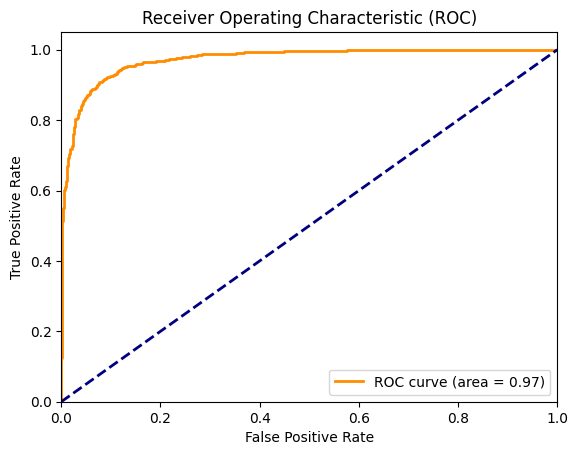

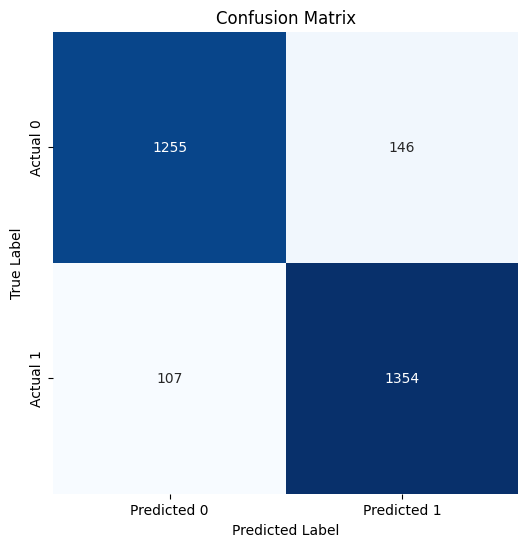

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import pandas as pd


# Fit the logistic regression model
np.random.seed(6251)
model = LogisticRegression(random_state=6251)
model.fit(tfidf_train, y_train)

# Make predictions on the test set
y_pred = model.predict(tfidf_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


# Display metrics in a table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})


print(metrics_df.to_string(index=False))


# Plot the ROC curve
y_pred_proba = model.predict_proba(tfidf_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

2. Naiive Bayes & Evaluation

Naive Bayes Model Performance:
   Metric    Value
 Accuracy 0.842068
Precision 0.852059
   Recall 0.835729
 F1 Score 0.843815


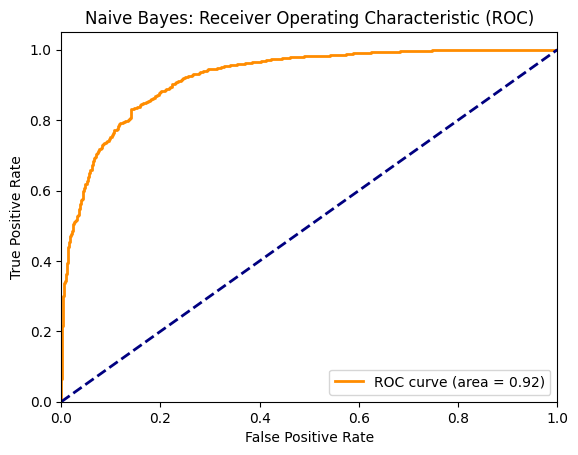

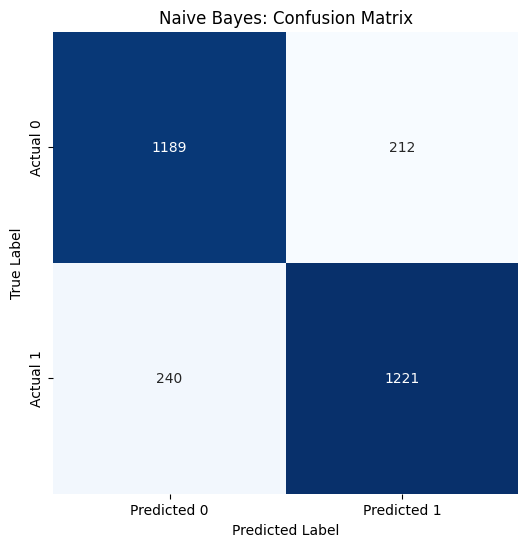

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Fit the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(tfidf_train, y_train)

# Make predictions on the test set
y_pred_nb = nb_model.predict(tfidf_test)

# Calculate evaluation metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

# Display metrics in a table
metrics_df_nb = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy_nb, precision_nb, recall_nb, f1_nb]
})

print("Naive Bayes Model Performance:")
print(metrics_df_nb.to_string(index=False))


# Plot the ROC curve for Naive Bayes
y_pred_proba_nb = nb_model.predict_proba(tfidf_test)[:, 1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_proba_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure()
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes: Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Plot the confusion matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Naive Bayes: Confusion Matrix')
plt.show()

3. Support Vector Macine & Evaluation (12 minutes execution time)

SVM Model Performance:
   Metric    Value
 Accuracy 0.932914
Precision 0.927849
   Recall 0.941821
 F1 Score 0.934783


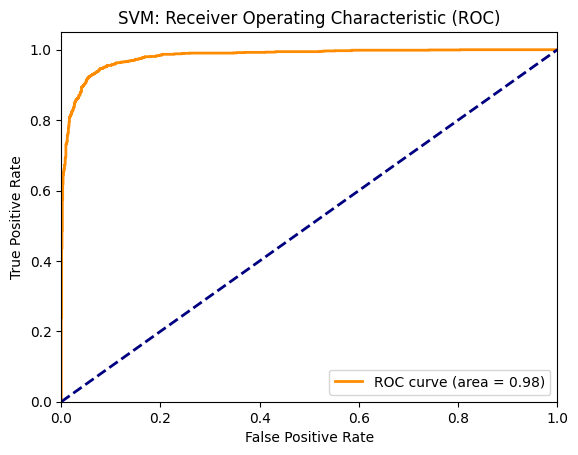

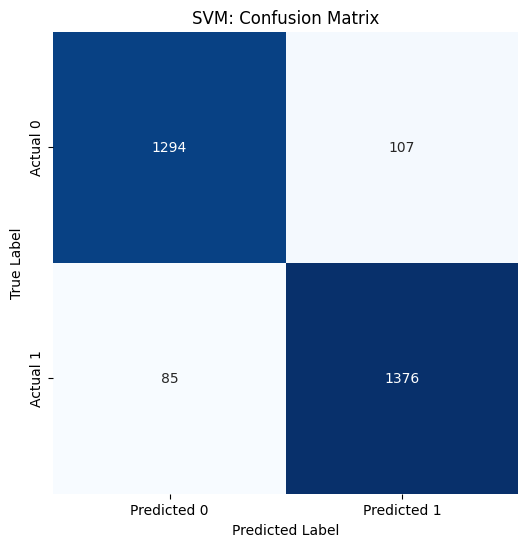

In [ ]:
from sklearn.svm import SVC

# Fit the SVM model
svm_model = SVC(kernel='linear', probability=True)  # You can experiment with different kernels
svm_model.fit(tfidf_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(tfidf_test)

# Calculate evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# Display metrics in a table
metrics_df_svm = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy_svm, precision_svm, recall_svm, f1_svm]
})

print("SVM Model Performance:")
print(metrics_df_svm.to_string(index=False))


# Plot the ROC curve for SVM
y_pred_proba_svm = svm_model.predict_proba(tfidf_test)[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM: Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Plot the confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM: Confusion Matrix')
plt.show()

# **CONCLUSION:  Final Model Selection & Closing Thoughts**

### **Algorithm Results Table**

| Sr. No. | ML Algorithm        | F1 Score |
|---------|----------------------|----------|
| 1       | SVM                  | 93.5     |
| 2       | Logistic Regression  | 91.4     |
| 3       | Naive Bayes          | 84.4     |

<br>

**Final Model Selection:** SVM


**Closing Thoughts**

<br>

**Objective & Performance:**

*   Tested three machine learning algorithms—Support Vector Machine (SVM), Logistic Regression, and Naive Bayes—to classify news articles as real or fake based on text.

*   SVM outperformed, achieving the highest accuracy, precision, recall, and AUC scores, followed by Logistic Regression and Naive Bayes.
<br>

**Limitations:**

*   Used a sample of the dataset due to computational limits.

*   Minimal Feature Engineering: Relied on TF-IDF without advanced features like n-grams or embeddings.

*   No Hyperparameter Tuning: This was a baseline project without parameter optimization.
<br>

**Future Improvements:**

*   Advanced Feature Engineering: Use word embeddings (e.g., Word2Vec, BERT) and expanded n-grams for richer context.

*   Deep Learning Models: Explore architectures like RNNs or Transformers for more sophisticated detection.

*   Optimization: Apply hyperparameter tuning and train on the full dataset if resources allow.
<br>

**Business Use Case:**
In a business context, this model could be deployed as a screening tool to flag potentially misleading or unreliable news sources in real time. Media companies, social platforms, and fact-checking agencies could integrate it to assist moderators or journalists in identifying and prioritizing content for further review. By streamlining this process, the model would support faster and more efficient content verification, helping to maintain credibility and reduce the spread of misinformation.


